# Import libraries

In [1]:
import numpy as np
import random
from numpy.linalg import*
import matplotlib.pyplot as plt
from numpy import r_, exp, cos, sin, pi, zeros, ones, hanning, sqrt, log, floor, reshape, mean
from scipy import signal,stats 
from numpy.fft import fft
import math
import time
from copy import deepcopy

import scipy.io as sio
import scipy.io.wavfile
import sounddevice as sd
from IPython.display import Audio

import copy
%matplotlib inline
import librosa
import librosa.display
from mpl_toolkits.mplot3d import Axes3D

import sklearn
from hmmlearn import hmm

# Problem 1. Some clustering

In [2]:
## Data import
x, fs = librosa.load('./HW4_data/P1/friends.wav', sr=None)

print(x.shape)
Audio(x,rate=fs)

(2389694,)


In [3]:
## truth label import
truth_time_raw = np.genfromtxt('./HW4_data/P1/labels.txt',usecols=[0,1])
truth_label_raw = np.genfromtxt('./HW4_data/P1/labels.txt',usecols=2, dtype=str)

## Class    : code
## speech:  :  1
## music:   :  2
## laughter :  3

truth_label_temp = np.zeros(len(truth_label_raw))
truth_label_full = []
truth_time_interval = (np.round(truth_time_raw[:,1]*fs)-np.round(truth_time_raw[:,0]*fs)).astype(int)

for i in range(len(truth_label_raw)):
    if truth_label_raw[i] == 'speech':
        truth_label_temp[i] = 1
    elif truth_label_raw[i] == 'music':
        truth_label_temp[i] = 2
    elif truth_label_raw[i] == 'laughter':
        truth_label_temp[i] = 3
    truth_label_full.append(np.repeat(truth_label_temp[i],truth_time_interval[i]).T)

truth_label_full = np.concatenate(truth_label_full).flatten()
truth_label = truth_label_full[::200]          ### Label to compare with our estimated labels !

(501, 11949)


Text(0.5, 1.0, 'Spectrogram')

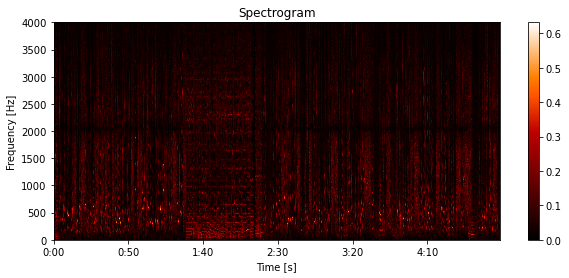

In [4]:
## perform STFT to get T-F bins 
N_fft = 1000
N_hop = 0.2*N_fft
f , t, X_ft = signal.stft(x, fs, window = 'hamming', nperseg=N_fft, noverlap = N_fft-N_hop,padded=False)
print(X_ft.shape)
X_plot = np.sqrt(np.abs(X_ft))
plt.figure(figsize=(10,4))
librosa.display.specshow(X_plot, sr=fs, x_axis='time', y_axis='linear', hop_length=N_hop ,cmap=plt.cm.gist_heat)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.colorbar()
plt.title("Spectrogram")


(501, 501)


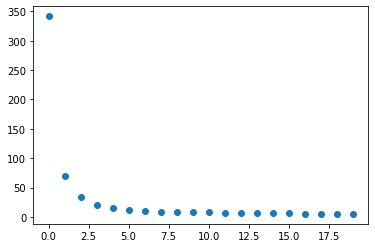

In [5]:
### STFT on training data
X = np.log(abs(X_ft)+1e-8)
X_mean = np.average(X,axis=1)  

##### : PCA #####
# Z = WX  
# where Z: weight matrix (10 x 9336), W: feature matrix (10 x 513), X: input matrix (513 x 9336)

X_cov = np.cov((X.T-X_mean).T, bias =True)
print(X_cov.shape)
EigVal, EigVec = np.linalg.eigh(X_cov)

sort_ind = np.argsort(EigVal)[::-1]
EigVal_sort = EigVal[sort_ind]
EigVec_sort = EigVec[:,sort_ind]
Disp = 20
plt.figure(0)
plt.plot(EigVal_sort[:Disp],'o')
########### select
N_sel = 10

EigVec_sel = EigVec_sort[:,:N_sel]

SigmaInv_sel = np.diag(1/np.sqrt(EigVal_sort[:N_sel]))

W_sel = SigmaInv_sel@np.transpose(EigVec_sel)
Z = W_sel@(X.T-X_mean).T

## i) K-means

In [6]:
def kmeans(Z,k):
    vec = Z.T
    # initialize centroids
    centroids = np.zeros((k, vec.shape[1]))
    vec_mean=np.mean(vec,axis=0)
    vec_std=np.std(vec,axis=0)
    for c in range(vec.shape[1]):
        centroids[:,c]=np.random.normal(vec_mean[c],vec_std[c],size=k)    


    labels=np.zeros(len(vec),dtype=np.uint8)
    n_iteration=1
    error = np.zeros(k)
    

    while True:
        # E-step: Assign data to nearest centroids
        for i in range(len(vec)):
            distances = np.zeros(k)
            for j in range(k):
                  distances[j] = np.linalg.norm(vec[i]-centroids[j],ord=2) 
            cluster = np.argmin(distances)
            labels[i] = cluster
      # M-step: Update the centroids
        centroids_old = deepcopy(centroids)
        for i in range(k):
            # Only save data that belongs to each centroids
            points = np.asarray([ vec[j] for j in range(len(vec)) if labels[j] == i ])
            # Set mean as new centroids but give random point if no data is assigned.
            if len(points) == 0:
                centroids[i] = vec[np.random.randint(low=0,high=vec.shape[0],size=1),:]

            else:
                centroids[i] = np.mean(points, axis=0)

      # Find error between previous and current centroids

        for i in range(k):
            error[i] = np.linalg.norm(centroids_old[i]-centroids[i],ord=2)
        
        
        print('Iteration {}'.format(n_iteration))
        #for i in range(k):
        #    print('k={} : (N points assigned : {})'.format(i + 1, np.count_nonzero(labels == i)))
        print('Difference :{}'.format(error.sum()))    
    
        n_iteration+=1
        if error.sum()<EPS:
            break
    return labels,centroids,n_iteration    

In [7]:
k = 3   ## giving 3 clusters 
EPS = 1e-5
labels,centroids,n_iteration = kmeans(Z,k)

Iteration 1
Difference :6.654523480031143
Iteration 2
Difference :0.6700172890660088
Iteration 3
Difference :0.42463910691320916
Iteration 4
Difference :0.4310679883117281
Iteration 5
Difference :0.5129234279775183
Iteration 6
Difference :0.4879159639088836
Iteration 7
Difference :0.3861938338023841
Iteration 8
Difference :0.29507141949277016
Iteration 9
Difference :0.27148576094677035
Iteration 10
Difference :0.2552543469163756
Iteration 11
Difference :0.23445209835920183
Iteration 12
Difference :0.21612212123136076
Iteration 13
Difference :0.18810851999392272
Iteration 14
Difference :0.15349195638711735
Iteration 15
Difference :0.1537642051138082
Iteration 16
Difference :0.1407222903321811
Iteration 17
Difference :0.14775529697699497
Iteration 18
Difference :0.16511123621421084
Iteration 19
Difference :0.17228714662847922
Iteration 20
Difference :0.20039448179434016
Iteration 21
Difference :0.20720169650895315
Iteration 22
Difference :0.20435036624108222
Iteration 23
Difference :0.16

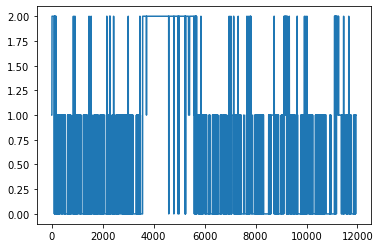

In [9]:
plt.plot(labels)

In [10]:
labels_comp = deepcopy(labels)


labels_comp[np.argwhere(labels ==1).flatten()] = 1   ## speech
labels_comp[np.argwhere(labels ==2).flatten()] = 2   ## music
labels_comp[np.argwhere(labels ==0).flatten()] = 3   ## laughter


print('Accuracy: {:.3} %'.format(100*len(np.argwhere(truth_label==labels_comp))/len(truth_label)) )

Accuracy: 76.0 %


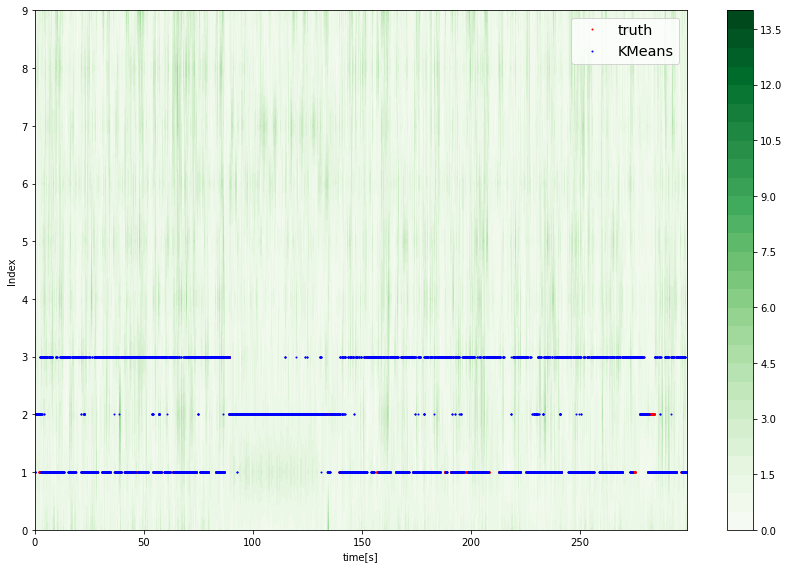

In [11]:
fig = plt.figure(figsize = (12,8))
CS = plt.contourf(t, np.arange(N_sel), abs(Z),cmap=plt.cm.Greens, levels = 30)
plt.colorbar(CS,orientation='vertical')

plt.plot(t,truth_label, '.', markersize=2,label='truth',color='r')
plt.plot(t,labels_comp, '.',markersize=2,label='KMeans',color='b')
plt.legend()
plt.legend(fontsize=20) # using a size in points
plt.legend(fontsize="x-large") # using a named size

plt.xlabel('time[s]')
plt.ylabel('Index')
plt.tight_layout()

## ii) GMM clustering

In [12]:
def GMM_clustering(Z,k):
    vec = Z.T      ## N x d 
    
    # initialize parameters: mean(mu), covariance(sigma), and prior(prior)
    mu = np.zeros((k, vec.shape[1]))       # k x d

    vec_mean=np.mean(vec,axis=0)           # 1 x d
    vec_std=np.std(vec,axis=0)             # 1 x d


    sigma = np.repeat(np.diag(vec_std**2)[np.newaxis,:,:], k, axis=0) # k x d x d      
    sigma_small = 1e-5*np.identity(len(vec[1]))   # d x d matrix to add on sigma to prevent singularity issue

    prior = np.ones(k)/k                   # 1 x k           start with uniform prior


    for d in range(vec.shape[1]):
        mu[:,d]=np.random.normal(vec_mean[d],vec_std[d],size=k)  ## start with gaussian random var for mu

    labels=np.zeros(len(vec),dtype=np.uint8)
    n_iteration=1

    ll = []   ## log likelihood per iteration
    ll_o = 1000
    
    

    while True:   ## for each iteration

        # E-step: Calculate posterior values for each data point for each cluster    
        poster = np.zeros((vec.shape[0],k))    ## N x k

        for m, s, pri, c in zip(mu, sigma, prior, range(k)):
            Gauss = stats.multivariate_normal(m,s+sigma_small)
            poster[:,c] = pri*Gauss.pdf(vec)/np.sum([pri_c*stats.multivariate_normal(m_c, s_c).pdf(vec) 
                                                       for m_c, s_c, pri_c  in zip(mu, sigma+sigma_small, prior)],axis=0)


        # M step: based on posterior values for each class, update mean, cov, prior
        for c in range(k):
            mu_c = np.sum(poster[:,c]*vec.T,axis=1)/np.sum(poster[:,c])
            sigma_c = poster[:,c]*(vec-mu_c).T@(vec-mu_c)/np.sum(poster[:,c])+sigma_small
            prior_c = np.sum(poster[:,c])/vec.shape[0]

            mu[c,:] = mu_c
            sigma[c,:,:] = sigma_c
            prior[c] = prior_c

        ## Log likelihood save

        ll_n = np.log(np.sum([q*stats.multivariate_normal(mu[i],sigma[j]).pdf(vec) 
                                 for q,i,j in zip(prior,range(len(mu)),range(len(sigma)))]))
        ll.append(ll_n)
        ll_error = abs(ll_n-ll_o)
        ll_o = deepcopy(ll_n)

        print('Iteration {}, log-likelihood = {:.5f}'.format(n_iteration, ll_n))

        n_iteration+=1
        if ll_error<EPS:
            break
    
    
    labels = np.argmax(poster,axis=1)
    
    return labels,mu,sigma, prior, n_iteration   

In [13]:
EPS = 1e-5
k = 3
labels_GMM,mu_GMM,sigma_GMM, prior_GMM, n_iteration_GMM = GMM_clustering(Z,k)

Iteration 1, log-likelihood = -2.47137
Iteration 2, log-likelihood = -2.31234
Iteration 3, log-likelihood = -2.20469
Iteration 4, log-likelihood = -2.08888
Iteration 5, log-likelihood = -1.98715
Iteration 6, log-likelihood = -1.93032
Iteration 7, log-likelihood = -1.89167
Iteration 8, log-likelihood = -1.85063
Iteration 9, log-likelihood = -1.79822
Iteration 10, log-likelihood = -1.73258
Iteration 11, log-likelihood = -1.65642
Iteration 12, log-likelihood = -1.58133
Iteration 13, log-likelihood = -1.53845
Iteration 14, log-likelihood = -1.51837
Iteration 15, log-likelihood = -1.50535
Iteration 16, log-likelihood = -1.49283
Iteration 17, log-likelihood = -1.47761
Iteration 18, log-likelihood = -1.45850
Iteration 19, log-likelihood = -1.43580
Iteration 20, log-likelihood = -1.40785
Iteration 21, log-likelihood = -1.37164
Iteration 22, log-likelihood = -1.32429
Iteration 23, log-likelihood = -1.26320
Iteration 24, log-likelihood = -1.17587
Iteration 25, log-likelihood = -1.02630
Iteration

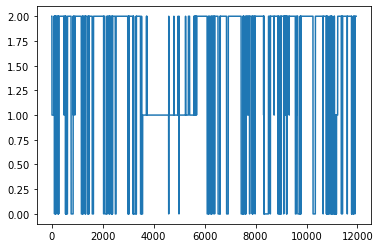

In [16]:
plt.plot(labels_GMM)

In [17]:
labels_GMM_comp = deepcopy(labels_GMM)


labels_GMM_comp[np.argwhere(labels_GMM ==2).flatten()] = 1   ## speech
labels_GMM_comp[np.argwhere(labels_GMM ==1).flatten()] = 2   ## music
labels_GMM_comp[np.argwhere(labels_GMM ==0).flatten()] = 3   ## laughter


print('Accuracy: {:.3} %'.format(100*len(np.argwhere(truth_label==labels_GMM_comp))/len(truth_label)) )

Accuracy: 90.8 %


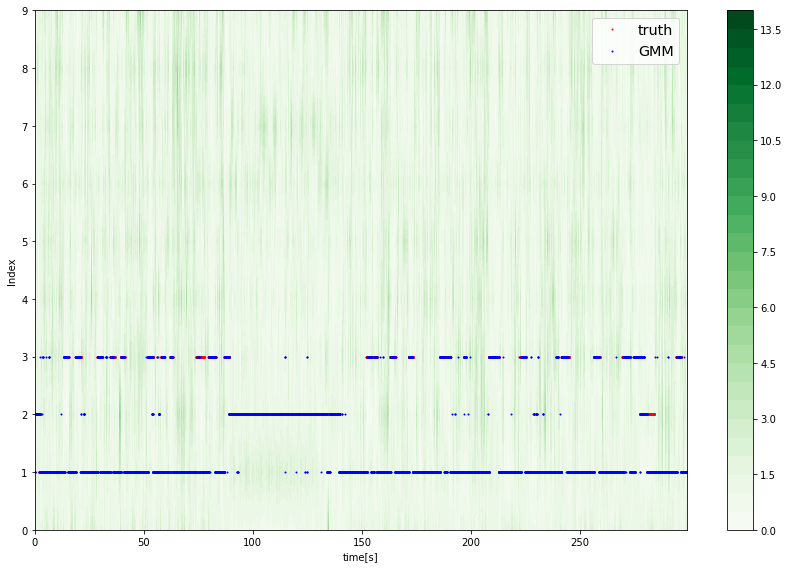

In [18]:
fig = plt.figure(figsize = (12,8))
CS = plt.contourf(t, np.arange(N_sel), abs(Z),cmap=plt.cm.Greens, levels = 30)
plt.colorbar(CS,orientation='vertical')

plt.plot(t,truth_label, '.', markersize=2,label='truth',color='r')
plt.plot(t,labels_GMM_comp, '.',markersize=2,label='GMM',color='b')
plt.legend()
plt.legend(fontsize=20) # using a size in points
plt.legend(fontsize="x-large") # using a named size

plt.xlabel('time[s]')
plt.ylabel('Index')
plt.tight_layout()

## iii) HMM clustering

In [19]:
model = hmm.GaussianHMM(n_components=3, covariance_type="full",algorithm='viterbi',n_iter=1000).fit(Z.T)

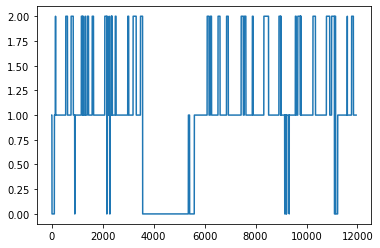

In [20]:
labels_HMM = model.predict(Z.T)
plt.plot(labels_HMM)


In [21]:
labels_HMM_comp = deepcopy(labels_HMM)


labels_HMM_comp[np.argwhere(labels_HMM ==1).flatten()] = 1   ## speech
labels_HMM_comp[np.argwhere(labels_HMM ==0).flatten()] = 2   ## music
labels_HMM_comp[np.argwhere(labels_HMM ==2).flatten()] = 3   ## laughter


print('Accuracy: {:.3} %'.format(100*len(np.argwhere(truth_label==labels_HMM_comp))/len(truth_label)) )

Accuracy: 92.1 %


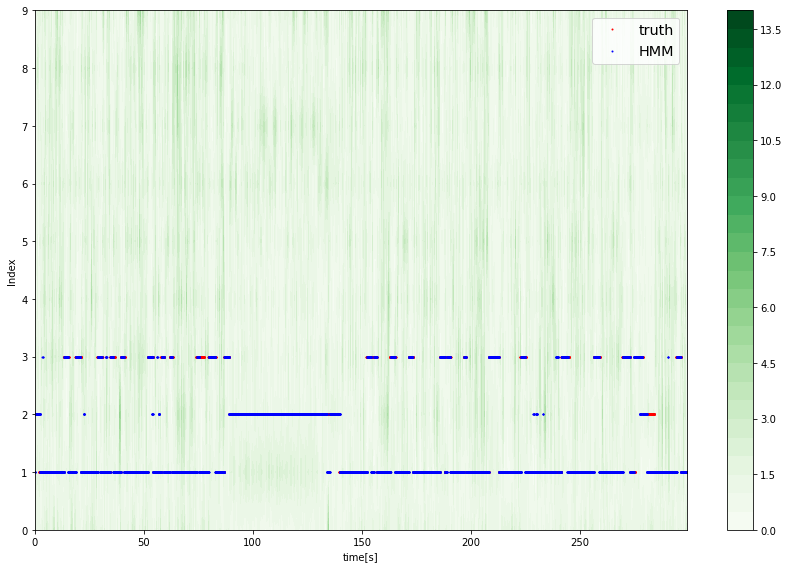

In [22]:
fig = plt.figure(figsize = (12,8))
CS = plt.contourf(t, np.arange(N_sel), abs(Z),cmap=plt.cm.Greens, levels = 30)
plt.colorbar(CS,orientation='vertical')

plt.plot(t,truth_label, '.', markersize=2,label='truth',color='r')
plt.plot(t,labels_HMM_comp, '.',markersize=2,label='HMM',color='b')
plt.legend()
plt.legend(fontsize=20) # using a size in points
plt.legend(fontsize="x-large") # using a named size

plt.xlabel('time[s]')
plt.ylabel('Index')
plt.tight_layout()

## - Accuracy Summary of Problem 1

| Approach    | KMeans| GMM | HMM |
| ----------- | ----- |-----|---- |
| Accuracy(%) |76.0   |90.8 |92.1 |

Comment: GMM & HMM outperforms K-Means because each cluster may not necessarily be circular-shaped in N_sel -dimensional space, and GMM & HMM (which both have Gaussian shape) can capture more complicated shapes of clusters with covariance matrix. Also, HMM outperforms GMM because it exploits time-domain information by incorporating the order of events while other two algorithms don't.

# Problem 2 Spoken Digit Learning using HMM

In [23]:
N_train = 15
N_test = 5
N_length = 50000
x_train = np.zeros((N_length, N_train, 10))
x_test = np.zeros((N_length,N_test,10))

digit = 0


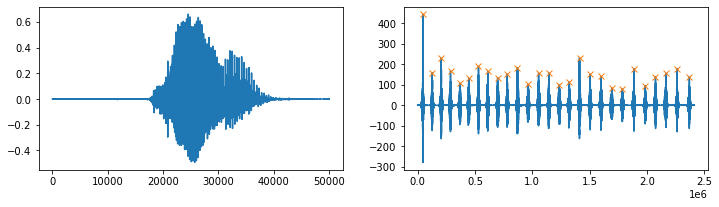

In [24]:
## 0
d = 0
print('digit = {}'.format(d))
N_start = 45000
N_length = 50000
data_test, fs = librosa.load('./HW4_data/P2/data/data-0.wav', sr=None)
plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.plot(data_test[N_start:N_start+N_length])
slider = data_test[N_start:N_start+N_length]
check_corr = scipy.signal.correlate(data_test, slider, mode='valid')
peaks,_ = signal.find_peaks(check_corr,distance=70000)
plt.subplot(122)
plt.plot(check_corr)
plt.plot(peaks,check_corr[peaks],"x")

count = 0
for i in range(30):

    if count<15:
        x_train[:,count,d] = data_test[peaks[i]:peaks[i]+N_length]
    else:
        x_test[:,count-15,d] = data_test[peaks[i]:peaks[i]+N_length]
    
    count += 1
    if count == 20:
               break
Audio(slider,rate=fs)

## 27 samples. ALl fine

digit = 1


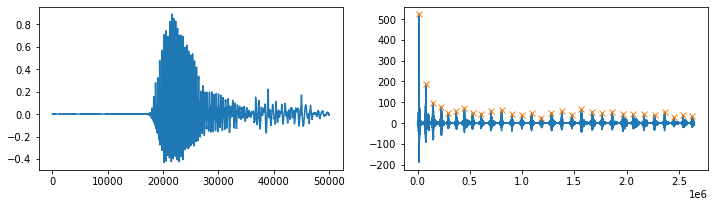

In [25]:
## 1
d = 1
print('digit = {}'.format(d))

N_start = 15000
N_length = 50000
data_test, fs = librosa.load('./HW4_data/P2/data/data-1.wav', sr=None)
plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.plot(data_test[N_start:N_start+N_length])
slider = data_test[N_start:N_start+N_length]
check_corr = scipy.signal.correlate(data_test, slider, mode='valid')
peaks,_ = signal.find_peaks(check_corr,distance=60000)
plt.subplot(122)
plt.plot(check_corr)
plt.plot(peaks,check_corr[peaks],"x")


count = 0
for i in range(30):

    if count<15:
        x_train[:,count,d] = data_test[peaks[i]:peaks[i]+N_length]
    else:
        x_test[:,count-15,d] = data_test[peaks[i]:peaks[i]+N_length]
    
    count += 1
    if count == 20:
               break
            
Audio(slider,rate=fs)




## 30 samples. Take first 20

digit = 2


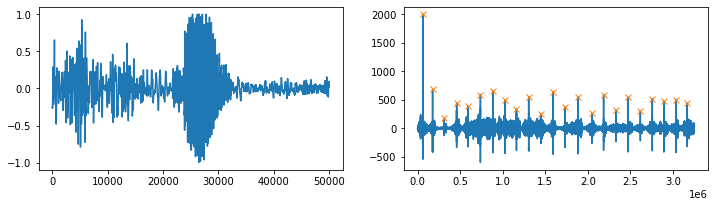

In [26]:
## 2

d = 2
print('digit = {}'.format(d))

N_start = 60000
N_length = 50000
data_test, fs = librosa.load('./HW4_data/P2/data/data-2.wav', sr=None)
plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.plot(data_test[N_start:N_start+N_length])
slider = data_test[N_start:N_start+N_length]
check_corr = scipy.signal.correlate(data_test, slider, mode='valid')
peaks,_ = signal.find_peaks(check_corr,distance=100000)
plt.subplot(122)
plt.plot(check_corr)
plt.plot(peaks,check_corr[peaks],"x")
Audio(slider,rate=fs)

count = 0
for i in range(30):

    if count<15:
        x_train[:,count,d] = data_test[peaks[i]:peaks[i]+N_length]
    else:
        x_test[:,count-15,d] = data_test[peaks[i]:peaks[i]+N_length]
    
    count += 1
    if count == 20:
               break
            
Audio(slider,rate=fs)



## 23 samples all fine

digit = 3


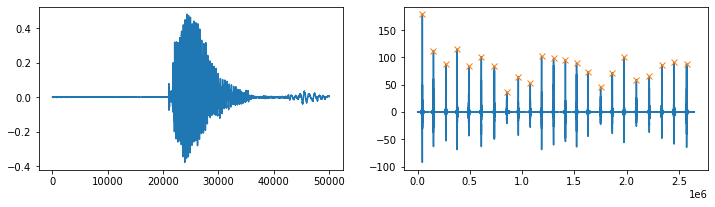

In [27]:
## 3
d = 3
print('digit = {}'.format(d))

N_start = 45000
N_length = 50000
data_test, fs = librosa.load('./HW4_data/P2/data/data-3.wav', sr=None)
plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.plot(data_test[N_start:N_start+N_length])
slider = data_test[N_start:N_start+N_length]
check_corr = scipy.signal.correlate(data_test, slider, mode='valid')
peaks,_ = signal.find_peaks(check_corr,distance=100000)
plt.subplot(122)
plt.plot(check_corr)
plt.plot(peaks,check_corr[peaks],"x")

count = 0
for i in range(30):

    if count<15:
        x_train[:,count,d] = data_test[peaks[i]:peaks[i]+N_length]
    else:
        x_test[:,count-15,d] = data_test[peaks[i]:peaks[i]+N_length]
    
    count += 1
    if count == 20:
               break
            
Audio(slider,rate=fs)





## 23 samples. Take first 20

digit = 4


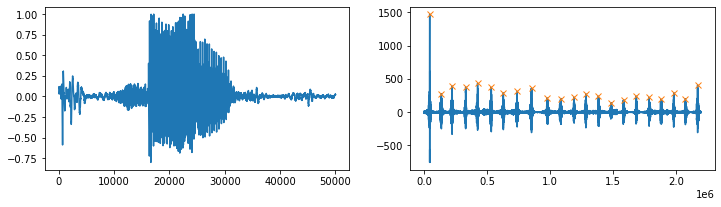

In [28]:
## 4

d = 4
print('digit = {}'.format(d))

N_start = 45000
N_length = 50000
data_test, fs = librosa.load('./HW4_data/P2/data/data-4.wav', sr=None)
plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.plot(data_test[N_start:N_start+N_length])
slider = data_test[N_start:N_start+N_length]
check_corr = scipy.signal.correlate(data_test, slider, mode='valid')
peaks,_ = signal.find_peaks(check_corr,distance=70000)
plt.subplot(122)
plt.plot(check_corr)
plt.plot(peaks,check_corr[peaks],"x")


count = 0
for i in range(30):

    if count<15:
        x_train[:,count,d] = data_test[peaks[i]:peaks[i]+N_length]
    else:
        x_test[:,count-15,d] = data_test[peaks[i]:peaks[i]+N_length]
    
    count += 1
    if count == 20:
               break
            
Audio(slider,rate=fs)


## 22 samples. All god

digit = 5


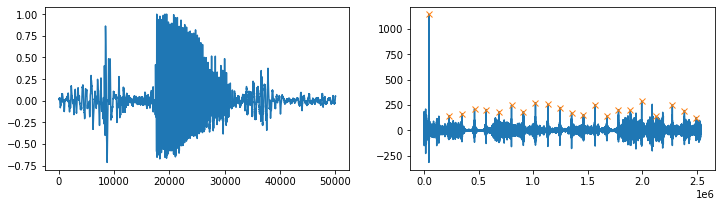

In [29]:
## 5
d = 5
print('digit = {}'.format(d))

N_start = 45000
N_length = 50000
data_test, fs = librosa.load('./HW4_data/P2/data/data-5.wav', sr=None)
plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.plot(data_test[N_start:N_start+N_length])
slider = data_test[N_start:N_start+N_length]
check_corr = scipy.signal.correlate(data_test, slider, mode='valid')
peaks,_ = signal.find_peaks(check_corr,distance=100000)
plt.subplot(122)
plt.plot(check_corr)
plt.plot(peaks,check_corr[peaks],"x")


count = 0
for i in range(30):
    if i == 18:
        continue

    if count<15:
        x_train[:,count,d] = data_test[peaks[i]:peaks[i]+N_length]
    else:
        x_test[:,count-15,d] = data_test[peaks[i]:peaks[i]+N_length]
    
    count += 1
    if count == 20:
               break
            
Audio(slider,rate=fs)



## 22 samples but eliminate index 18

digit = 6


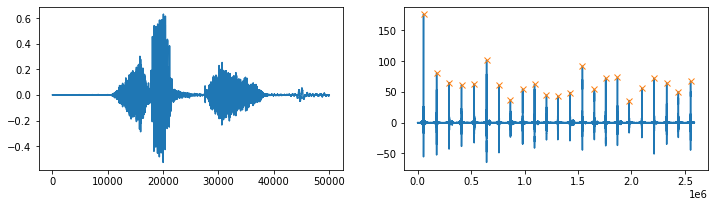

In [30]:
## 6

d = 6
print('digit = {}'.format(d))

N_start = 55000
N_length = 50000
data_test, fs = librosa.load('./HW4_data/P2/data/data-6.wav', sr=None)
plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.plot(data_test[N_start:N_start+N_length])
slider = data_test[N_start:N_start+N_length]
check_corr = scipy.signal.correlate(data_test, slider, mode='valid')
peaks,_ = signal.find_peaks(check_corr,distance=100000)
plt.subplot(122)
plt.plot(check_corr)
plt.plot(peaks,check_corr[peaks],"x")

count = 0
for i in range(30):


    if count<15:
        x_train[:,count,d] = data_test[peaks[i]:peaks[i]+N_length]
    else:
        x_test[:,count-15,d] = data_test[peaks[i]:peaks[i]+N_length]
    
    count += 1
    if count == 20:
               break
            
Audio(slider,rate=fs)


## 23 samples. Take first 20

digit = 7


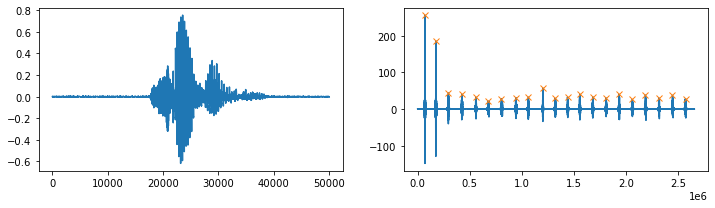

In [31]:
## 7

d = 7
print('digit = {}'.format(d))

N_start = 70000
N_length = 50000
data_test, fs = librosa.load('./HW4_data/P2/data/data-7.wav', sr=None)
plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.plot(data_test[N_start:N_start+N_length])
slider = data_test[N_start:N_start+N_length]
check_corr = scipy.signal.correlate(data_test, slider, mode='valid')
peaks,_ = signal.find_peaks(check_corr,distance=100000)
plt.subplot(122)
plt.plot(check_corr)
plt.plot(peaks,check_corr[peaks],"x")


count = 0
for i in range(30):
    if i == 18:
        continue

    if count<15:
        x_train[:,count,d] = data_test[peaks[i]:peaks[i]+N_length]
    else:
        x_test[:,count-15,d] = data_test[peaks[i]:peaks[i]+N_length]
    
    count += 1
    if count == 20:
               break
            
Audio(slider,rate=fs)


## 21 samples. take first 20 samples.

digit = 8


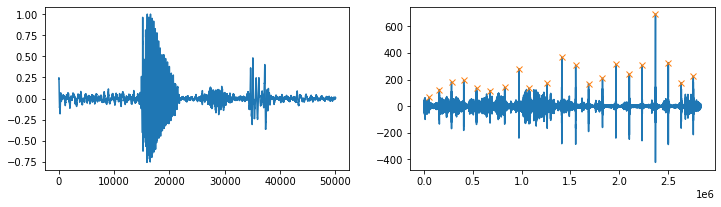

In [32]:
## 8
d = 8
print('digit = {}'.format(d))

N_start = 2372304
N_length = 50000
data_test, fs = librosa.load('./HW4_data/P2/data/data-8.wav', sr=None)
plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.plot(data_test[N_start:N_start+N_length])
slider = data_test[N_start:N_start+N_length]
check_corr = scipy.signal.correlate(data_test, slider, mode='valid')
peaks,_ = signal.find_peaks(check_corr,distance=100000)
plt.subplot(122)
plt.plot(check_corr)
plt.plot(peaks,check_corr[peaks],"x")


count = 0
for i in range(30):
    if i == 8:
        continue

    if count<15:
        x_train[:,count,d] = data_test[peaks[i]:peaks[i]+N_length]
    else:
        x_test[:,count-15,d] = data_test[peaks[i]:peaks[i]+N_length]
    
    count += 1
    if count == 20:
               break
            
Audio(slider,rate=fs)


## Out of 21 peaks, get rid of index 8.

digit = 9


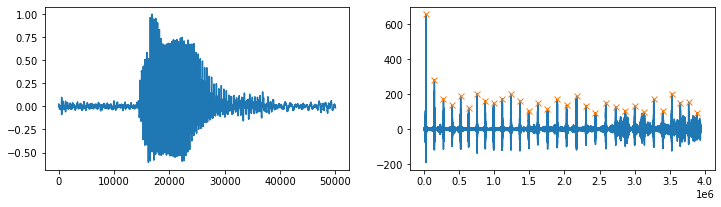

In [33]:
## 9
d = 9
print('digit = {}'.format(d))

N_length = 50000
data_test, fs = librosa.load('./HW4_data/P2/data/data-9.wav', sr=None)
plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.plot(data_test[25000:25000+N_length])
slider = data_test[25000:25000+N_length]
check_corr = scipy.signal.correlate(data_test, slider, mode='valid')
peaks,_ = signal.find_peaks(check_corr,distance=100000)
plt.subplot(122)
plt.plot(check_corr)
plt.plot(peaks,check_corr[peaks],"x")

count = 0
for i in range(30):
    if count<15:
        x_train[:,count,d] = data_test[peaks[i]:peaks[i]+N_length]
    else:
        x_test[:,count-15,d] = data_test[peaks[i]:peaks[i]+N_length]
    
    count += 1
    if count == 20:
               break
            
Audio(slider,rate=fs)

## Take first 20 samples

In [ ]:
print(len(peaks))
i+=1
print(i)

Audio(data_test[peaks[i]:peaks[i]+N_length],rate=fs)

In [38]:
X_train_mean.shape

(501,)

In [36]:
_,_, out = signal.stft(np.reshape(x_train,(-1),order='F'), fs, window = 'hamming', nperseg=N_fft, noverlap = N_fft-N_hop)
X_ft_train_flat = np.log(abs(out))
f,t,_ = signal.stft(x_train[:,0,0], fs, window = 'hamming', nperseg=N_fft, noverlap = N_fft-N_hop)
X_ft_train = np.zeros((len(f),len(t), N_train, 10))     ## 513 x 197 x 15 x 10
X_ft_test = np.zeros((len(f),len(t), N_test,  10))      ## 513 x 197 x 5 x 10

for i in range(10):
    for j in range(N_train):
        f,t,out = signal.stft(x_train[:,j,i], fs, window = 'hamming', nperseg=N_fft, noverlap = N_fft-N_hop)
        X_ft_train[:,:,j,i] = np.log(abs(out)) 
    for j in range(N_test):
        f,t,out = signal.stft(x_test[:,j,i], fs, window = 'hamming', nperseg=N_fft, noverlap = N_fft-N_hop)
        X_ft_test[:,:,j,i] = np.log(abs(out)) 



(501, 501)
[1052.2428836   117.33419825   30.87084125   13.50339706   10.74163296
    7.19145592    6.47103673    5.08312847    4.29711089    3.98884791]
(5, 251, 15, 10)


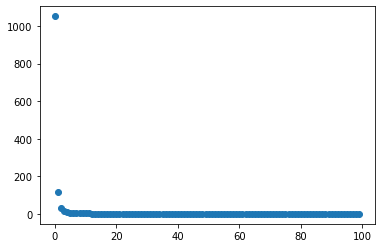

In [39]:
X_train_mean = np.average(X_ft_train_flat,axis=1)

##### : PCA #####
# Z = WX  
# where Z: weight matrix (8 x 197), W: feature matrix (8 x 513), X: input matrix (513 x 197)


X_cov = np.cov((X_ft_train_flat.T-X_train_mean).T, bias =True) + 1e-5*np.diag(np.ones(X_train_mean.shape))
print(X_cov.shape)
EigVal, EigVec = np.linalg.eigh(X_cov)

sort_ind = np.argsort(EigVal)[::-1]
EigVal_sort = EigVal[sort_ind]
EigVec_sort = EigVec[:,sort_ind]
Disp = 100
plt.figure(0)
plt.plot(EigVal_sort[:Disp],'o')
print(EigVal_sort[:10])

N_sel = 5

EigVec_sel = EigVec_sort[:,:N_sel]
SigmaInv_sel = np.diag(1/np.sqrt(EigVal_sort[:N_sel]))

W_sel = SigmaInv_sel@np.transpose(EigVec_sel)
Z_ft_train = np.einsum('ij,jklm->iklm', W_sel,(X_ft_train.T-X_train_mean).T)
print(Z_ft_train.shape)

In [40]:
## Learn the GMM-HMM parameters


n_states = 4
n_mixture = 2


transmat = np.zeros((n_states, n_states))
for i in range(n_states):
    if i == n_states-1:
        transmat[i, i] = 1.0
    else:
        transmat[i, i] = 0.5
        transmat[i, i+1] = 0.5

# Always start in first state
startprob = np.zeros(n_states)
startprob[0] = 1.0

model_GH_array = []
for i in range(10):
    Z_concat = np.reshape(Z_ft_train[...,i], (N_sel,-1),order='F')
    model_GH = hmm.GMMHMM(n_components=n_states, n_mix=n_mixture, covariance_type='full')#,  
                         # init_params='cmw')

    #model_GH.startprob_ = startprob
    #model_GH.transmat_ = transmat
    model_GH.fit(Z_concat.T, lengths =Z_concat.shape[1])
    print(np.round(model_GH.transmat_, decimals=2))
    model_GH_array.append(model_GH)
    
#model_GH = hmm.GaussianHMM(n_components=n_states, covariance_type='diag', algorithm='viterbiy', 
#                      params='cmt', init_params='cm')





[[0.99 0.   0.01 0.  ]
 [0.   0.98 0.02 0.  ]
 [0.04 0.01 0.92 0.03]
 [0.   0.02 0.   0.98]]
[[0.96 0.02 0.   0.01]
 [0.03 0.97 0.01 0.  ]
 [0.01 0.   0.98 0.01]
 [0.03 0.   0.02 0.95]]
[[0.95 0.   0.01 0.04]
 [0.   0.98 0.   0.02]
 [0.03 0.04 0.87 0.06]
 [0.04 0.   0.02 0.94]]
[[0.98 0.01 0.   0.  ]
 [0.   0.98 0.   0.02]
 [0.01 0.   0.98 0.01]
 [0.01 0.02 0.04 0.93]]
[[0.95 0.   0.05 0.  ]
 [0.01 0.97 0.   0.03]
 [0.03 0.01 0.96 0.  ]
 [0.02 0.   0.   0.98]]
[[0.95 0.02 0.   0.03]
 [0.01 0.96 0.02 0.01]
 [0.01 0.01 0.98 0.  ]
 [0.02 0.01 0.   0.97]]
[[0.97 0.   0.01 0.02]
 [0.   0.98 0.01 0.02]
 [0.02 0.01 0.97 0.  ]
 [0.02 0.02 0.01 0.95]]
[[0.98 0.   0.   0.02]
 [0.   0.96 0.03 0.  ]
 [0.   0.   0.98 0.02]
 [0.06 0.02 0.   0.92]]
[[0.96 0.01 0.   0.03]
 [0.   0.94 0.05 0.01]
 [0.   0.06 0.91 0.03]
 [0.01 0.02 0.03 0.93]]
[[0.89 0.05 0.03 0.03]
 [0.03 0.94 0.04 0.  ]
 [0.01 0.02 0.97 0.  ]
 [0.01 0.01 0.   0.98]]


In [54]:
## Evaluation with training data
acc_train = np.zeros(10)
pred_train = []
truth_label_train = []
for i in range(10):
    score = 0 
    for j in range(N_train):
        temp = []
        for k in range(10):
            temp.append(model_GH_array[k].score(Z_ft_train[:,:,j,i].T))
        if np.argmax(temp) == i:
            score += 1
        pred_train.append(np.argmax(temp))
        truth_label_train.append(i)
        #print(np.argmax(temp))
    acc_train[i] = score/N_train

In [55]:
## Evaluation with testing data
acc_test = np.zeros(10)
Z_ft_test = np.einsum('ij,jklm->iklm', W_sel,(X_ft_test.T-X_train_mean).T)
pred_test = []
truth_label_test = []
for i in range(10):
    score = 0 
    for j in range(N_test):
        temp = []
        for k in range(10):
            temp.append(model_GH_array[k].score(Z_ft_test[:,:,j,i].T))
        if np.argmax(temp) == i:
            score += 1
        pred_test.append(np.argmax(temp))
        truth_label_test.append(i)
        #print(np.argmax(temp))
    acc_test[i] = score/N_test

In [61]:
print("Accuracy from training data (%) for each digit", 100* acc_train)
print("Accuracy from training data (%) for each digit", 100* acc_test)

Accuracy from training data (%) for each digit [100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
Accuracy from training data (%) for each digit [100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


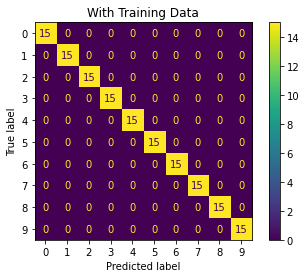

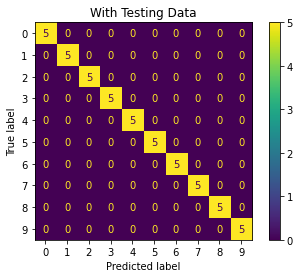

In [60]:
## Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_train = confusion_matrix(truth_label_train, pred_train, labels=np.arange(10))
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                              display_labels=np.arange(10))
cm_test = confusion_matrix(truth_label_test, pred_test, labels=np.arange(10))
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                              display_labels=np.arange(10))


disp_train.plot() 
plt.title('With Training Data')
disp_test.plot()
plt.title('With Testing Data')
plt.show()

Comment: Optimized GMM HMM parameter to get highest accuracy which is 100% for all digits.

# Problem 3: Activity Recognition

In [64]:
# data import:  
# 1: Walking, 2:Walking_upstairs, 3: Walking_downstairs, 4: Sitting, 5: Standing, 6: Laying

x_raw = np.genfromtxt('./HW4_data/P3/data/total_acc_x_test.txt')
y_raw = np.genfromtxt('./HW4_data/P3/data/total_acc_y_test.txt')
z_raw = np.genfromtxt('./HW4_data/P3/data/total_acc_z_test.txt')
data_raw = np.stack([x_raw,y_raw,z_raw],axis=2)

label_raw = np.genfromtxt('./HW4_data/P3/data/y-test.txt')
## data only with 4 labels (1,2,3,4)  1878 x 128 x 3
data = np.delete(data_raw, np.concatenate([np.argwhere(label_raw == 5).flatten(), 
                                                np.argwhere(label_raw == 6).flatten()]), axis=0)
## corresponding 4 labels
label = np.delete(label_raw, np.concatenate([np.argwhere(label_raw == 5).flatten(), 
                                                np.argwhere(label_raw == 6).flatten()]))
#data_w = data_raw[np.argwhere(label_raw==1).flatten(),:,:]  ## walking
#data_u = data_raw[np.argwhere(label_raw==2).flatten(),:,:]  ## walking upstairs 
#data_d = data_raw[np.argwhere(label_raw==3).flatten(),:,:]  ## walking downstairs
#data_s = data_raw[np.argwhere(label_raw==4).flatten(),:,:]  ## sitting


rand_array = np.random.choice(len(data),int(len(data)*0.5))
print(rand_array.shape)

data_train = data[rand_array,:,:]
data_test = np.delete(data, rand_array,axis=0)
label_train = label[rand_array]
label_test = np.delete(label, rand_array)

temp_train = []   ## contains w, u, d, s train data in order (index 0 1 2 3)
temp_test = []    ## contains w, u, d, s test data in order (index 0 1 2 3)
for i in range(4):
    temp_train.append(data_train[np.argwhere(label_train==i+1).flatten(),:,:])
    temp_test.append(data_test[np.argwhere(label_test==i+1).flatten(),:,:])

(939,)


In [65]:
data_train.shape

(939, 128, 3)

In [66]:
temp_train[0].shape

(230, 128, 3)

In [ ]:
## Set up the linear equation (Original v1: includes bias for each vector)
T = len(data_train[1])    ## Length of data given  =  128
N = 10                      ## Hyperparameter for VAR(N)

## Per sample equation: Dout         =    A        Din
##                     (3x(T-N))     (3x4N)    (4N x (T-N))

def Matgen_sample(T, N, temp_data, label_ind, sample_ind):
    out_temp = []
    in_temp = []

    for i in range(T-N):
        out_temp.append(temp_data[label_ind][sample_ind,T-i-1,:])
        in_temp_col = []
        for j in range(N):
            in_temp_col.append(np.concatenate((temp_data[label_ind][sample_ind,T-i-2,:],[1])))

        in_temp.append(np.array(in_temp_col).flatten())
    Dout = np.array(out_temp).T   
    Din = np.array(in_temp).T
    return Dout, Din

## Per label(activity) with all sample:  [Dout1  ... Dout_Ntrain] = A      [Din1 ... Din_Ntrain]
##                                          (3 x Ntrain(T-N))       (3x4N)     (4N x Ntrain(T-N))\

def Matgen(T, N, temp_data, label_ind):
    OUT_mat = []
    IN_mat = []
    for i in range(temp_data[label_ind].shape[0]): 

        Dout, Din = Matgen_sample(T,N,temp_data,label_ind,i)
        OUT_mat.append(Dout.T)
        IN_mat.append(Din.T)

    OUT = np.array(OUT_mat).T.reshape((3,-1),order='F')
    IN = np.array(IN_mat).T.reshape((4*N,-1),order='F')  
    A = OUT@np.linalg.pinv(IN)
    return A


def Eval(T, N, temp_data, A, label_ind, sample_ind):
    Dout, Din = Matgen_sample(T,N,temp_data,label_ind,sample_ind)
    error = A@Din - Dout
    
    return error


In [67]:
## Set up the linear equation (v2: one bias):
T = len(data_train[1])    ## Length of data given  =  128
N = 10                      ## Hyperparameter for VAR(N)

## Per sample equation: Dout         =    A        Din
##                     (3x(T-N))     (3x(3N+1))    ((3N+1) x (T-N))

def Matgen_sample(T, N, temp_data, label_ind, sample_ind):
    out_temp = []
    in_temp = []

    for i in range(T-N):
        out_temp.append(temp_data[label_ind][sample_ind,T-i-1,:])
        in_temp_col = []
        for j in range(N):
            in_temp_col.append(temp_data[label_ind][sample_ind,T-i-2,:])
        #print(np.concatenate(np.array(in_temp_col).flatten(),[1]))
        in_temp.append(np.concatenate((np.array(in_temp_col).flatten(),[1])))
    Dout = np.array(out_temp).T   
    Din = np.array(in_temp).T
    return Dout, Din

## Per label(activity) with all sample:  [Dout1  ... Dout_Ntrain] = A      [Din1 ... Din_Ntrain]
##                                          (3 x Ntrain(T-N))       (3x(3N+1))     ((3N+1) x Ntrain(T-N))

def Matgen(T, N, temp_data, label_ind):
    OUT_mat = []
    IN_mat = []
    for i in range(temp_data[label_ind].shape[0]): 

        Dout, Din = Matgen_sample(T,N,temp_data,label_ind,i)
        OUT_mat.append(Dout.T)
        IN_mat.append(Din.T)

    OUT = np.array(OUT_mat).T.reshape((3,-1),order='F')
    IN = np.array(IN_mat).T.reshape((3*N+1,-1),order='F')  
    A = OUT@np.linalg.pinv(IN)
    error = np.average(A@IN - OUT,axis=1)
    return A, error


def Eval(T, N, temp_data, A, label_ind, sample_ind):
    Dout, Din = Matgen_sample(T,N,temp_data,label_ind,sample_ind)
    error = A@Din - Dout

    return error


### Check mean square error (MSE) for each class for randomly single training data to see the pattern first.

In [74]:
mse_0_temp = []
mse_1_temp = []
mse_2_temp = []
mse_3_temp = []
sample_ind = 100
for n in range(126):
    Dout, Din = Matgen_sample(T, n, temp_train, 0, sample_ind)
    A_mat = Dout@np.linalg.pinv(Din)
    mse_0_temp.append(np.mean((A_mat@Din - Dout)**2))
    
    Dout, Din = Matgen_sample(T, n, temp_train, 1, sample_ind)
    A_mat = Dout@np.linalg.pinv(Din)
    mse_1_temp.append(np.mean((A_mat@Din - Dout)**2))
    
    Dout, Din = Matgen_sample(T, n, temp_train, 2, sample_ind)
    A_mat = Dout@np.linalg.pinv(Din)
    mse_2_temp.append(np.mean((A_mat@Din - Dout)**2))
    
    Dout, Din = Matgen_sample(T, n, temp_train, 3, sample_ind)
    A_mat = Dout@np.linalg.pinv(Din)
    mse_3_temp.append(np.mean((A_mat@Din - Dout)**2))

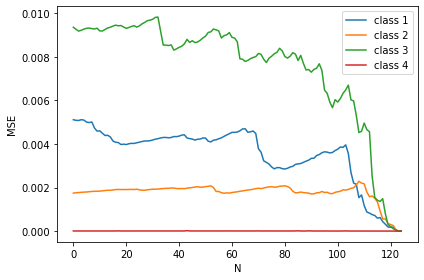

In [73]:
## sample index = 10
plt.plot(mse_0_temp[1:],label='class 1')
plt.plot(mse_1_temp[1:],label='class 2')
plt.plot(mse_2_temp[1:],label='class 3')
plt.plot(mse_3_temp[1:],label='class 4')
plt.xlabel('N')
plt.ylabel('MSE')
plt.legend()
plt.tight_layout()

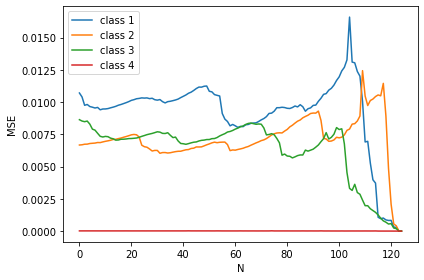

In [75]:
## Sample index = 100
plt.plot(mse_0_temp[1:],label='class 1')
plt.plot(mse_1_temp[1:],label='class 2')
plt.plot(mse_2_temp[1:],label='class 3')
plt.plot(mse_3_temp[1:],label='class 4')
plt.xlabel('N')
plt.ylabel('MSE')
plt.legend()
plt.tight_layout()

 After trying out several example trial cases, it could be observed that intrinsic MSE level is different and there are specific range of variation of MSE level for each class. (For instance, red line(class = 4) always stays low regardless of sample index and N values.
 
 let us find average MSE for each class using all training data together by concatenating those in both input and output. Then compare that with test data's mse to identify its class by comparing distance between MSEs. 
 
 This is eventually including average MSE values for each class to the loss function for classification 

In [170]:
### Training with value N that gives best accuracy.(needs iteration)
N = 80
mse_0_train = []
mse_1_train = []
mse_2_train = []
mse_3_train = []

for ind in range(temp_train[0].shape[0]):
    Dout, Din = Matgen_sample(T, N, temp_train, 0, ind)
    A_mat_0 = Dout@np.linalg.pinv(Din)
    mse_0_train.append(np.mean((A_mat_0@Din - Dout)**2))
    
for ind in range(temp_train[1].shape[0]):
    Dout, Din = Matgen_sample(T, N, temp_train, 1, ind)
    A_mat_1 = Dout@np.linalg.pinv(Din)
    mse_1_train.append(np.mean((A_mat_1@Din - Dout)**2))    
    
for ind in range(temp_train[2].shape[0]):
    Dout, Din = Matgen_sample(T, N, temp_train, 2, ind)
    A_mat_2 = Dout@np.linalg.pinv(Din)
    mse_2_train.append(np.mean((A_mat_2@Din - Dout)**2))
    
for ind in range(temp_train[3].shape[0]):
    Dout, Din = Matgen_sample(T, N, temp_train, 3, ind)
    A_mat_3 = Dout@np.linalg.pinv(Din)
    mse_3_train.append(np.mean((A_mat_3@Din - Dout)**2))    

mse_train = np.array([np.average(mse_0_train),np.average(mse_1_train),np.average(mse_2_train),np.average(mse_3_train)])
print('Trained mse values :', mse_train)

Trained mse values : [7.65326620e-03 4.66905808e-03 9.33959899e-03 1.95258078e-05]


In [171]:
### Evaluation
def Eval_func(label_ind, temp_data, T,N, A0,A1,A2,A3,mse_train):
    mse_0_test = []
    mse_1_test = []
    mse_2_test = []
    mse_3_test = []

    for ind in range(temp_data[label_ind].shape[0]):
        Dout, Din = Matgen_sample(T, N, temp_data, label_ind, ind)
        mse_0_test.append(np.mean((A0@Din - Dout)**2))
        mse_1_test.append(np.mean((A1@Din - Dout)**2))
        mse_2_test.append(np.mean((A2@Din - Dout)**2))
        mse_3_test.append(np.mean((A3@Din - Dout)**2))
    mse_test = np.array([mse_0_test,mse_1_test,mse_2_test,mse_3_test]).T
    classifier = np.argmin((mse_test-mse_train)**2,axis=1)
    acc = len(np.argwhere(classifier == label_ind))/len(classifier)
    return classifier, acc

## Evaluate with training samples
class_train_0, acc_train_0 = Eval_func(0, temp_train, T,N, A_mat_0,A_mat_1,A_mat_2,A_mat_3, mse_train)
class_train_1, acc_train_1 = Eval_func(1, temp_train, T,N, A_mat_0,A_mat_1,A_mat_2,A_mat_3, mse_train)
class_train_2, acc_train_2 = Eval_func(2, temp_train, T,N, A_mat_0,A_mat_1,A_mat_2,A_mat_3, mse_train)
class_train_3, acc_train_3 = Eval_func(3, temp_train, T,N, A_mat_0,A_mat_1,A_mat_2,A_mat_3, mse_train)
## Evaluate with testing samples 
class_test_0, acc_test_0 = Eval_func(0, temp_test, T,N, A_mat_0,A_mat_1,A_mat_2,A_mat_3, mse_train)
class_test_1, acc_test_1 = Eval_func(1, temp_test, T,N, A_mat_0,A_mat_1,A_mat_2,A_mat_3, mse_train)
class_test_2, acc_test_2 = Eval_func(2, temp_test, T,N, A_mat_0,A_mat_1,A_mat_2,A_mat_3, mse_train)
class_test_3, acc_test_3 = Eval_func(3, temp_test, T,N, A_mat_0,A_mat_1,A_mat_2,A_mat_3, mse_train)

In [103]:
print('For the selection of N =', N)
print('Accuracy with training data (%): {:.3}, {:.3}, {:.3}, {:.3} and average of {:.3} '
      .format(100*acc_train_0,100*acc_train_1,100*acc_train_2,100*acc_train_3, 
             100* np.average([acc_train_0,acc_train_1,acc_train_2,acc_train_3])))
print('Accuracy with  testing data (%): {:.3}, {:.3}, {:.3}, {:.3} and average of {:.3}'
      .format(100*acc_test_0,100*acc_test_1,100*acc_test_2,100*acc_test_3,
             100* np.average([acc_test_0,acc_test_1,acc_test_2,acc_test_3])))

For the selection of N = 10
Accuracy with training data (%): 63.5, 36.6, 63.0, 61.1 and average of 56.1 
Accuracy with  testing data (%): 70.2, 37.8, 67.5, 62.0 and average of 59.4


In [110]:
print('For the selection of N =', N)
print('Accuracy with training data (%): {:.3}, {:.3}, {:.3}, {:.3} and average of {:.3} '
      .format(100*acc_train_0,100*acc_train_1,100*acc_train_2,100*acc_train_3, 
             100* np.average([acc_train_0,acc_train_1,acc_train_2,acc_train_3])))
print('Accuracy with  testing data (%): {:.3}, {:.3}, {:.3}, {:.3} and average of {:.3}'
      .format(100*acc_test_0,100*acc_test_1,100*acc_test_2,100*acc_test_3,
             100* np.average([acc_test_0,acc_test_1,acc_test_2,acc_test_3])))

For the selection of N = 30
Accuracy with training data (%): 54.3, 46.9, 63.9, 60.7 and average of 56.5 
Accuracy with  testing data (%): 57.9, 49.8, 62.3, 57.6 and average of 56.9


In [116]:
print('For the selection of N =', N)
print('Accuracy with training data (%): {:.3}, {:.3}, {:.3}, {:.3} and average of {:.3} '
      .format(100*acc_train_0,100*acc_train_1,100*acc_train_2,100*acc_train_3, 
             100* np.average([acc_train_0,acc_train_1,acc_train_2,acc_train_3])))
print('Accuracy with  testing data (%): {:.3}, {:.3}, {:.3}, {:.3} and average of {:.3}'
      .format(100*acc_test_0,100*acc_test_1,100*acc_test_2,100*acc_test_3,
             100* np.average([acc_test_0,acc_test_1,acc_test_2,acc_test_3])))

For the selection of N = 50
Accuracy with training data (%): 47.8, 44.0, 68.0, 54.7 and average of 53.6 
Accuracy with  testing data (%): 52.4, 49.1, 66.3, 53.9 and average of 55.4


In [119]:
print('For the selection of N =', N)
print('Accuracy with training data (%): {:.3}, {:.3}, {:.3}, {:.3} and average of {:.3} '
      .format(100*acc_train_0,100*acc_train_1,100*acc_train_2,100*acc_train_3, 
             100* np.average([acc_train_0,acc_train_1,acc_train_2,acc_train_3])))
print('Accuracy with  testing data (%): {:.3}, {:.3}, {:.3}, {:.3} and average of {:.3}'
      .format(100*acc_test_0,100*acc_test_1,100*acc_test_2,100*acc_test_3,
             100* np.average([acc_test_0,acc_test_1,acc_test_2,acc_test_3])))

For the selection of N = 70
Accuracy with training data (%): 54.3, 39.5, 56.2, 63.6 and average of 53.4 
Accuracy with  testing data (%): 61.2, 44.3, 62.3, 62.3 and average of 57.5


In [176]:
print('For the selection of N =', N)
print('Accuracy with training data (%): {:.3}, {:.3}, {:.3}, {:.3} and average of {:.3} '
      .format(100*acc_train_0,100*acc_train_1,100*acc_train_2,100*acc_train_3, 
             100* np.average([acc_train_0,acc_train_1,acc_train_2,acc_train_3])))
print('Accuracy with  testing data (%): {:.3}, {:.3}, {:.3}, {:.3} and average of {:.3}'
      .format(100*acc_test_0,100*acc_test_1,100*acc_test_2,100*acc_test_3,
             100* np.average([acc_test_0,acc_test_1,acc_test_2,acc_test_3])))

For the selection of N = 80
Accuracy with training data (%): 58.3, 28.8, 63.9, 53.4 and average of 51.1 
Accuracy with  testing data (%): 65.7, 36.8, 63.5, 51.5 and average of 54.4


In [122]:
print('For the selection of N =', N)
print('Accuracy with training data (%): {:.3}, {:.3}, {:.3}, {:.3} and average of {:.3} '
      .format(100*acc_train_0,100*acc_train_1,100*acc_train_2,100*acc_train_3, 
             100* np.average([acc_train_0,acc_train_1,acc_train_2,acc_train_3])))
print('Accuracy with  testing data (%): {:.3}, {:.3}, {:.3}, {:.3} and average of {:.3}'
      .format(100*acc_test_0,100*acc_test_1,100*acc_test_2,100*acc_test_3,
             100* np.average([acc_test_0,acc_test_1,acc_test_2,acc_test_3])))

For the selection of N = 90
Accuracy with training data (%): 43.5, 8.23, 72.6, 58.3 and average of 45.7 
Accuracy with  testing data (%): 45.3, 13.1, 69.8, 54.9 and average of 45.8


In [125]:
print('For the selection of N =', N)
print('Accuracy with training data (%): {:.3}, {:.3}, {:.3}, {:.3} and average of {:.3} '
      .format(100*acc_train_0,100*acc_train_1,100*acc_train_2,100*acc_train_3, 
             100* np.average([acc_train_0,acc_train_1,acc_train_2,acc_train_3])))
print('Accuracy with  testing data (%): {:.3}, {:.3}, {:.3}, {:.3} and average of {:.3}'
      .format(100*acc_test_0,100*acc_test_1,100*acc_test_2,100*acc_test_3,
             100* np.average([acc_test_0,acc_test_1,acc_test_2,acc_test_3])))

For the selection of N = 110
Accuracy with training data (%): 5.65, 2.06, 95.4, 36.8 and average of 35.0 
Accuracy with  testing data (%): 5.83, 3.44, 96.0, 36.7 and average of 35.5


## - Accuracy Summary for each N

### w/ Training data
| N    | Class 1 | Class 2 | Class 3 | Class 4 | Average |
| ---- | -----   |-----    |----     |  -----  |----    |
| 10   |63.5    |36.6     |63.0     |   61.1      | 56.1        |
| 30   |54.3     |46.9     |63.9    |  60.7       |  56.5       |
| 50   |76.0     |44.0| 68.0| 54.7 | 53.6
| 70   |54.3|39.5| 56.2| 63.6 |53.4 
| 80  |58.3| 28.8| 63.9| 53.4 |51.1 
| 90  |43.5| 8.23| 72.6| 58.3 |45.7 
| 110  |5.65| 2.06| 95.4| 36.8 |35.0 

### w/ Test data
| N    | Class 1 | Class 2 | Class 3 | Class 4 | Average |
| ---- | -----   |-----    |----     |  -----  |----    |
| 10   |70.2    |37.8     |67.5     |   62.0      | 59.4        |
| 30   |57.9     |49.8     |62.3     |  57.6       | 56.9       |
| 50   |52.4| 49.1| 66.3| 53.9 | 55.4
| 70   |61.2| 44.3| 62.3| 62.3 | 57.5
| 80   | 65.7| 36.8| 63.5| 51.5 |54.4
| 90  |45.3| 13.1| 69.8|54.9 |45.8
| 110  |5.83| 3.44| 96.0| 36.7 | 35.5


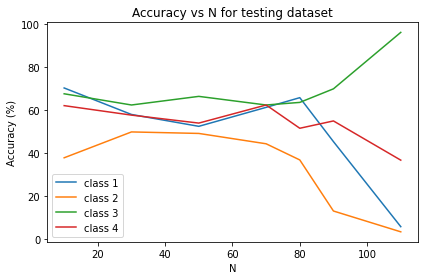

In [177]:
N_array = [10,30,50,70,80, 90,110]
Class_1_array = [70.2, 57.9, 52.4, 61.2, 65.7, 45.3, 5.83]
Class_2_array = [37.8, 49.8, 49.1, 44.3, 36.8, 13.1, 3.44]
Class_3_array = [67.5, 62.3, 66.3, 62.3,63.5, 69.8, 96]
Class_4_array = [62, 57.6, 53.9, 62.3,51.5, 54.9, 36.7]
plt.plot(N_array, Class_1_array, label='class 1')
plt.plot(N_array, Class_2_array, label='class 2')
plt.plot(N_array, Class_3_array, label='class 3')
plt.plot(N_array, Class_4_array, label='class 4')
plt.xlabel('N')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs N for testing dataset')
plt.legend()
plt.tight_layout()

### As can be seen, performance of each class reacts differently as N changes. 57 % average accuracy achieved overall if N = 30, but accuracy gets over 60 % at N = 70 ~ 90 if ignoring class 2. 
### Let us pick (N=30, 80) and plot confusion matrix respectively.

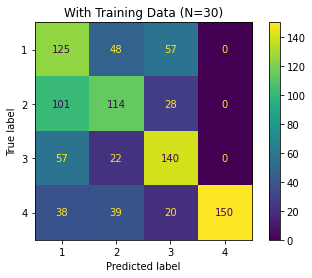

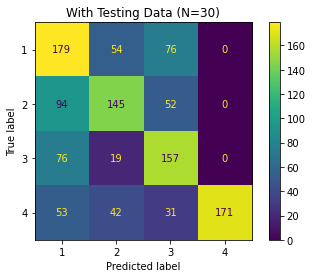

In [169]:
pred_train = np.concatenate([class_train_0, class_train_1, class_train_2, class_train_3])
pred_test = np.concatenate([class_test_0, class_test_1, class_test_2, class_test_3])
truth_label_train = np.concatenate([0* np.ones(len(class_train_0)), 1*np.ones(len(class_train_1)), 2* np.ones(len(class_train_2)), 3*np.ones(len(class_train_3))])
truth_label_test = np.concatenate([0* np.ones(len(class_test_0)), 1*np.ones(len(class_test_1)), 2* np.ones(len(class_test_2)), 3*np.ones(len(class_test_3))])

## Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_train = confusion_matrix(truth_label_train, pred_train, labels=np.arange(4))
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                              display_labels=np.arange(4)+1)
cm_test = confusion_matrix(truth_label_test, pred_test, labels=np.arange(4))
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                              display_labels=np.arange(4)+1)


disp_train.plot() 
plt.title('With Training Data (N=30)')
disp_test.plot()
plt.title('With Testing Data (N=30)')
plt.show()

### This is for N=30 case. It seems that class 4 is clearly different from class 1,2,3 because all classes 1-3 never been misjudged as class 4. Also, likelihood of missing 4 is also lowest.

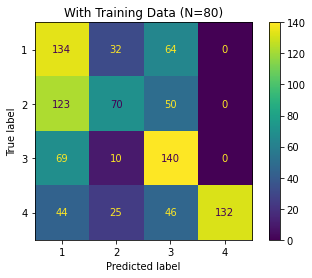

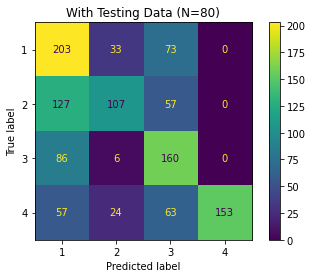

In [174]:
pred_train = np.concatenate([class_train_0, class_train_1, class_train_2, class_train_3])
pred_test = np.concatenate([class_test_0, class_test_1, class_test_2, class_test_3])
truth_label_train = np.concatenate([np.zeros(len(class_train_0)), 1*np.ones(len(class_train_1)), 2* np.ones(len(class_train_2)), 3*np.ones(len(class_train_3))])
truth_label_test = np.concatenate([np.zeros(len(class_test_0)), 1*np.ones(len(class_test_1)), 2* np.ones(len(class_test_2)), 3*np.ones(len(class_test_3))])

## Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_train = confusion_matrix(truth_label_train, pred_train, labels=np.arange(4))
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                              display_labels=np.arange(4)+1)
cm_test = confusion_matrix(truth_label_test, pred_test, labels=np.arange(4))
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                              display_labels=np.arange(4)+1)


disp_train.plot() 
plt.title('With Training Data (N=80)')
disp_test.plot()
plt.title('With Testing Data (N=80)')
plt.show()

### This is for N=80 case. Similarly, class 4 is exceptional whilst class 1, 3, 4 outperforms over class 2.

### Reason why model cannot learn well: In my opinion, matrix A that we learn is a linear estimator but we are introducing varying shape of functions over time but still keep one A at all times.

### One approach to make things better using linear estimators is to learn multiple values of A for each time index instead of learning just one A to incorporate temporal environment at that time t. 